# Goal

* regress out diet covariant from OTU abundance
* use resulting residuals for phylogenetic signal of particular taxa

# Var

In [1]:
work_dir = '/ebio/abt3_projects/Georg_animal_feces/data/host_specific/phylosignal/host_TT/taxon_abund/'

# phyloseq
physeq_file = '/ebio/abt3_projects/Georg_animal_feces/data/16S/LLA/phyloseq/physeq_r5k.RDS'

# sparsity 
sparsity_cutoff = 0.05

# Init

In [2]:
library(dplyr)
library(tidyr)
library(ggplot2)
library(ape)
library(phyloseq)
source('/ebio/abt3_projects/Georg_animal_feces/code/init.R') 


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [3]:
make_dir(work_dir)
setwd(work_dir)

Directory already exists: /ebio/abt3_projects/Georg_animal_feces/data/host_specific/phylosignal/host_TT/taxon_abund/ 


# Load

In [4]:
physeq = readRDS(physeq_file)
physeq

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 30290 taxa and 213 samples ]
sample_data() Sample Data:       [ 213 samples by 171 sample variables ]
tax_table()   Taxonomy Table:    [ 30290 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 30290 tips and 29752 internal nodes ]

In [5]:
# applying sparsity cutoff
physeq = physeq %>%
    filter_taxa(function(x) sum(x > 0) / length(x) > sparsity_cutoff, TRUE) 
physeq

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 408 taxa and 213 samples ]
sample_data() Sample Data:       [ 213 samples by 171 sample variables ]
tax_table()   Taxonomy Table:    [ 408 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 408 tips and 406 internal nodes ]

In [6]:
# OTUs
otu = physeq %>%
    otu_table() %>%
    as.matrix %>%
    as.data.frame 

otu %>% dim

[1] 408 213

In [7]:
metadata = physeq  %>%
    sample_data %>%
    as.matrix %>%
    as.data.frame %>%
    dplyr::select(-BarcodeSequence, -LinkerPrimerSequence, -Primer, -ReversePrimer, 
                  -Nanodrop_ng_per_ul_DNA, -Picogreen_ng_ul, -tot_mass, -height_or_length, 
                  -medication, -last_meal_or_actual_feed, -freezing_date, -samp_store_temp, 
                  -extr_mass_g, -dilution_qPCR, -Ct_A, -Ct_B, -Amount_SYBR_copies_in_5_ul_A, 
                  -Amount_SYBR_copies_in_5_ul_B, -Amount_geometric_mean_SYBR, 
                  -Copies_in_5_ul_PCR_template, -PCR_dil_qPCR_2, -Ct_A_2, -Ct_B_2, 
                  -Amount_SYBR_copies_in_5_ul_A_2, -Amount_SYBR_copies_in_5_ul_B_2,
                  -Amount_geometric_mean_SYBR_2, -Copies_in_5_ul_PCR_template_2, 
                  -Copies_per_100_ul_extract_2, -wellplate_Illumina, -wellplate_position_Illumina)

metadata %>% status

Warning message in class(X) <- NULL:
“Setting class(x) to NULL;   result will no longer be an S4 object”

[1] 213 141


,X.SampleID,Barcode_ID,sample_number,host_subject_id,host_german_name,host_common_name,scientific_name,scientific_name_subspecies,host_taxid,class,⋯,Cornell_Illumina,Cornell_Dilution_DNA_Illumina,Num_Illumina,Num,sorting_454,comments_additional,DNA_box_20180622,sample_vol_20180622,sample_label_20180622,Description
X1.Eurasian.Beaver,X1.Eurasian.Beaver,338R_BC0049,1,1,Biber,Eurasian.Beaver,Castor_fiber,NA,10185,Mammalia,⋯,yes,4,120,18,18,NA,1,20,1,NA
X101.Horse,X101.Horse,338R_BC0030,101,101,Hauspferd,Horse,Equus_caballus,NA,9796,Mammalia,⋯,yes,16,344,160,160,NA,2,20,101,NA
X102.Kulan,X102.Kulan,338R_BC0031,102,102,Khulan,Kulan,Equus_hemionus,Equus hemionus kulan,73334,Mammalia,⋯,yes,16,345,161,161,NA,2,20,102,NA


# Regressing out diet

In [8]:
setdiff(colnames(otu), rownames(metadata)) %>% print
setdiff(rownames(metadata), colnames(otu)) %>% print

character(0)
character(0)


In [9]:
metadata = metadata[colnames(otu),]
metadata %>% status

[1] 213 141


,X.SampleID,Barcode_ID,sample_number,host_subject_id,host_german_name,host_common_name,scientific_name,scientific_name_subspecies,host_taxid,class,⋯,Cornell_Illumina,Cornell_Dilution_DNA_Illumina,Num_Illumina,Num,sorting_454,comments_additional,DNA_box_20180622,sample_vol_20180622,sample_label_20180622,Description
X1.Eurasian.Beaver,X1.Eurasian.Beaver,338R_BC0049,1,1,Biber,Eurasian.Beaver,Castor_fiber,NA,10185,Mammalia,⋯,yes,4,120,18,18,NA,1,20,1,NA
X101.Horse,X101.Horse,338R_BC0030,101,101,Hauspferd,Horse,Equus_caballus,NA,9796,Mammalia,⋯,yes,16,344,160,160,NA,2,20,101,NA
X102.Kulan,X102.Kulan,338R_BC0031,102,102,Khulan,Kulan,Equus_hemionus,Equus hemionus kulan,73334,Mammalia,⋯,yes,16,345,161,161,NA,2,20,102,NA


In [10]:
to_binary = function(x){
    x = gsub(' .+', '', x)
    stopifnot(x %in% c('yes', 'no'))
    ifelse(x=='yes', 1, 0)
}

# variables to binary
diet_detail = metadata %>%
    dplyr::select(X.SampleID,diet_vertebrate,diet_invertebrate,
                  diet_fruit,diet_flowers_nectar_pollen,
                  diet_leaves_branches_bark_buds,diet_seeds,
                  diet_grass_waterplants,diet_roots_tubers) %>%
    mutate(
        diet_vertebrate = to_binary(diet_vertebrate),
        diet_invertebrate = to_binary(diet_invertebrate),
        diet_fruit = to_binary(diet_fruit),
        diet_flowers_nectar_pollen = to_binary(diet_flowers_nectar_pollen),
        diet_leaves_branches_bark_buds = to_binary(diet_leaves_branches_bark_buds),
        diet_seeds = to_binary(diet_seeds),
        diet_grass_waterplants = to_binary(diet_grass_waterplants),
        diet_roots_tubers = to_binary(diet_roots_tubers)
    ) 

# formatting
rownames(diet_detail) = diet_detail$X.SampleID
diet_detail$X.SampleID = NULL
diet_detail = diet_detail[colnames(otu),]

# status
diet_detail %>% status

[1] 213   8


,diet_vertebrate,diet_invertebrate,diet_fruit,diet_flowers_nectar_pollen,diet_leaves_branches_bark_buds,diet_seeds,diet_grass_waterplants,diet_roots_tubers
X1.Eurasian.Beaver,0,0,0,0,1,0,1,1
X101.Horse,0,0,0,0,0,1,1,0
X102.Kulan,0,0,0,0,1,0,1,0


In [11]:
regress_out = function(X, covariates){
    if(class(covariates) != 'data.frame'){
        covariates = as.data.frame(covariates)
    } 
    if(ncol(covariates) == 1){
        cols = c('X', 'Y')
        f = as.formula('X ~ Y')
    } else {
        cols = c('X', colnames(covariates))
        f = c('X ~', paste(colnames(covariates), collapse=' + '))
        f = as.formula(paste(f, collapse=' '))
    }
    df = cbind(as.data.frame(X), covariates)
    colnames(df) = cols
    lm(f, data=df)$residuals
}


otu_res = apply(otu, 1, regress_out, covariates=diet_detail) %>%
    t %>% scale %>% as.data.frame
otu_res %>% dim

[1] 408 213

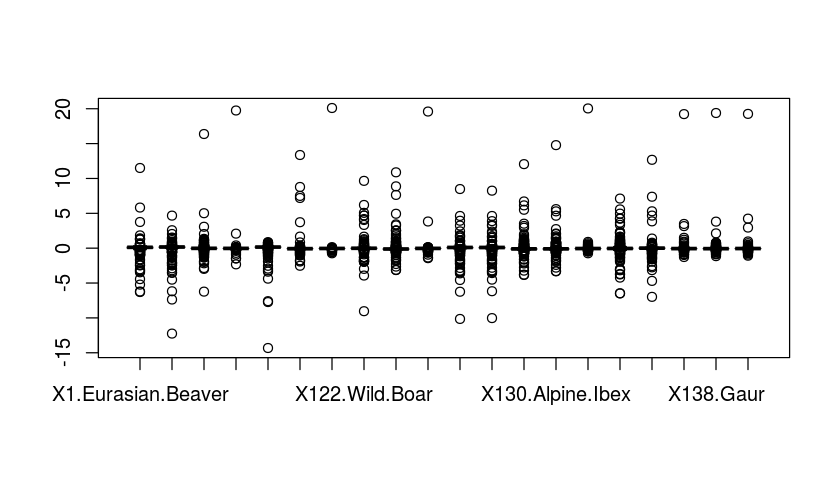

In [12]:
# checking scaled residuals
options(repr.plot.height=4)
boxplot(otu_res[,1:20])

In [13]:
otu_res %>% rowSums %>% summary %>% print
otu_res %>% colSums %>% summary %>% print

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-435.163    8.380    9.749    0.000   10.116   14.249 
      Min.    1st Qu.     Median       Mean    3rd Qu.       Max. 
-7.480e-15 -1.326e-15  1.115e-16  2.233e-16  1.877e-15  8.531e-15 


## Writing out OTU table

In [14]:
resid_otu_file = file.path(work_dir, 'physeq_IndD_OTU-diet-resid.RDS')
saveRDS(otu_res, file=resid_otu_file)
cat('File written:', resid_otu_file, '\n')

File written: /ebio/abt3_projects/Georg_animal_feces/data/host_specific/phylosignal/host_TT/taxon_abund//physeq_IndD_OTU-diet-resid.RDS 


# OTUs as binomial

In [15]:
otu_binom = otu %>%
    apply(2, function(x) ifelse(x > 0, 1, 0)) %>%
    as.data.frame 
          
otu_binom %>% as.matrix %>% as.vector %>% table %>% print
          
otu_binom %>% status

.
    0     1 
80827  6077 
[1] 408 213


,X1.Eurasian.Beaver,X101.Horse,X102.Kulan,X109.Red.Fox,X110.Noctule,X111.West.European.Hedgehog,X116.Common.Kestrel,X122.Wild.Boar,X123.Alpine.Chamois,X124.Golden.Jackal,⋯,F45.Red.Deer,F47.Red.Deer,F48.Red.Deer,F53.Mouflon,F66.Wild.Boar,F68.Red.Deer,F69.Red.Deer,F70.Red.Deer,F80.Red.Deer,F90.Domestic.Dog
368bd5c2255f3a5ce0fef06ca6de1d04,0,0,0,0,0,0,0,1,1,0,⋯,0,0,0,0,0,0,0,0,0,0
779324e5648460c5a67e577c45131b42,0,0,0,0,0,0,0,0,1,0,⋯,0,0,0,0,0,0,0,0,0,0
b918d185ee89a0b33d821ee766d76eb3,0,0,0,0,0,0,0,0,0,0,⋯,1,1,1,1,0,1,1,1,1,0


In [16]:
regress_out_binom = function(X, covariates){
    if(class(covariates) != 'data.frame'){
        covariates = as.data.frame(covariates)
    } 
    if(ncol(covariates) == 1){
        cols = c('X', 'Y')
        f = as.formula('X ~ Y')
    } else {
        cols = c('X', colnames(covariates))
        f = c('X ~', paste(colnames(covariates), collapse=' + '))
        f = as.formula(paste(f, collapse=' '))
    }
    df = cbind(as.data.frame(X), covariates)
    colnames(df) = cols
    glm(f, data=df, family='binomial')$residuals
}


otu_res = apply(otu_binom, 1, regress_out, covariates=diet_detail) %>%
    t %>% scale %>% as.data.frame
otu_res %>% dim

[1] 408 213

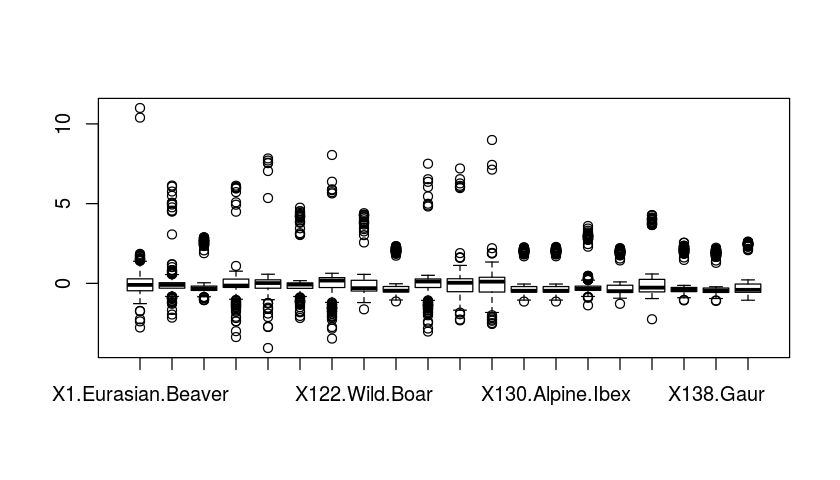

In [17]:
# checking scaled residuals
options(repr.plot.height=4)
boxplot(otu_res[,1:20])

In [18]:
otu_res %>% rowSums %>% summary %>% print
otu_res %>% colSums %>% summary %>% print

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-30.0407  -5.8560  -0.8778   0.0000   3.3266  69.7654 
      Min.    1st Qu.     Median       Mean    3rd Qu.       Max. 
-4.767e-14 -4.514e-15  1.466e-16 -2.530e-16  4.385e-15  2.377e-14 


## Writing out OTU table

In [19]:
resid_otu_file = file.path(work_dir, 'physeq_IndD-binom_OTU-diet-resid.RDS')
saveRDS(otu_res, file=resid_otu_file)
cat('File written:', resid_otu_file, '\n')

File written: /ebio/abt3_projects/Georg_animal_feces/data/host_specific/phylosignal/host_TT/taxon_abund//physeq_IndD-binom_OTU-diet-resid.RDS 


# sessionInfo

In [20]:
sessionInfo()

R version 3.4.1 (2017-06-30)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 16.04.4 LTS

Matrix products: default
BLAS: /ebio/abt3_projects/software/miniconda3/envs/py3_physeq/lib/R/lib/libRblas.so
LAPACK: /ebio/abt3_projects/software/miniconda3/envs/py3_physeq/lib/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] bindrcpp_0.2    phyloseq_1.22.3 ape_5.1         ggplot2_2.2.1  
[5] tidyr_0.8.1     dplyr_0.7.4    

loaded via a namespace (and not attached):
 [1] pbdZMQ_0.3-1        repr_0.12.0         purrr_0.2.4        